# Segmentacja zgłoszeń w systemie JIRA przy wykorzystaniu algorytmów centroidów i analizy sentymentu komentarzy użytkowników

 W zarządzaniu produktem informatycznym ważne jest podejmowanie trafnych decyzji, które w większości przypadków nie są trywialne. W procesie wytwórczym produktu informatycznego jednym z głównych i kluczowych elementów procesu jest etap testowania oprogramowania. Oprócz testów jednostkowych, deweloperskich automatycznych czy testów regresji coraz większą rolę przykłada się do testów użytkowników, którzy zgłaszają błędy, sugestie i usprawnienia dot. produktu informatycznego. Jednym ze znanych systemów do zgłaszania błędów i uwag jest system JIRA. Nadając publiczny dostęp do systemu JIRA dla swojego produktu informatycznego dla szerokiej liczby użytkowników liderzy testów trafiają na problem z ustaleniem priorytetyzacji zgłoszeń. Z jednej strony właściciel produktu chce, aby wszystkie zgłoszenia zostały zrealizowane, jednak z drugiej strony, posiada ograniczony zespół dewelopersko-testowy, który nie jest w stanie wszystkich zmian wdrożyć. Głównym przedmiotem niniejszej pracy jest wykonanie segmentacji takich zgłoszeń przy wykorzystaniu algorytmów centroidów i wykorzystując analizę wydźwięku emocji komentarzy użytkowników. Wynik segmentacji  będzie prowadził do wydzielenia zgłoszeń, które od strony użytkownika są priorytetowe do realizacji i budzą wiele emocji, co będzie prowadziło do usprawnienia selekcji priorytetowych zgłoszeń. Praca opisuje także samo podejście do problemu, jak również pokazuje w sposób szczegółowy opis wykorzystanych algorytmów, metryk oraz przedstawia proces przetwarzania danych

# 1.Instalacja narzędzi

In [1]:
#!pip install Faker

In [2]:
#!pip install vaderSentiment

In [3]:
#!pip3 install pyclustering

In [4]:
#!pip install kmodes

In [5]:
#!pip install -U scikit-learn

In [6]:
#!pip install boto3

In [7]:
#!pip3 install nltk

# 2. Import bibliotek

In [8]:
from jira import JIRA

In [9]:
import pandas as pd

In [10]:
import numpy as np

In [11]:
import seaborn as sns

In [12]:
from textblob import TextBlob

In [13]:
import matplotlib.pyplot as plt

In [14]:
from matplotlib.pyplot import figure

In [15]:
import warnings
warnings.filterwarnings('ignore')

# 2.Import danych z JIRA

## 2.1 Definicja zmiennych 

Definicja połączenia do projektu JIRA

In [16]:
JIRA_URL="https://jira.atlassian.com/"

Definicja projektu

In [17]:
JIRA_PROJECT="FishEye"

Ilość maksymalnych zgłoszeń pobranych przez JIRA. Domyślnie dla projektów jest ustawione na 1000 zgłoszeń importu na każde połączenie. Parametr ten może zmienić administrator projektu JIRA.

In [18]:
JIRA_MAX_RESULTS=1000

## 2.2 Łączenie się do serwera JIRA

Ustawienie opcji połączenia do serwea JIRY

In [19]:
options = { 'server': JIRA_URL, 'verify':False}

In [20]:
JIRA_KEY=JIRA(options)

Ustawienie zapytania JQL do selekcji danych z JIRA.
Wybieramy zadania z wybranego projektu, które posiadają <b>status jest różny od CLOSED, DONE i CANCELLED </b>

In [21]:
JIRA_JQL='project = "{}" and status not in ("CLOSED","DONE","CANCELLED") '.format(JIRA_PROJECT) 

Wykonanie zapytania do serwera JIRA

In [22]:
JIRA_SEARCH=JIRA_KEY.search_issues(JIRA_JQL, maxResults=JIRA_MAX_RESULTS)

## 2.3 Import zgłoszeń z JIRY

Mapowanie danych z JIRA do dataframe

In [23]:
JIRA_Issues=pd.DataFrame()
for issue in JIRA_SEARCH:
    JIRA_Issues= JIRA_Issues.append(
    {
        'key': issue.key, 
        'summary': issue.fields.summary,
        'assignee' : issue.fields.assignee,
        'reporter' : issue.fields.reporter,
        'votes' : str(issue.fields.votes),
        'watchCount' : str(issue.fields.watches.watchCount),
        'created' : issue.fields.created,
        'updated' : issue.fields.updated, 
        'status' :issue.fields.status, 
        'resolution' :issue.fields.resolution,  
    }, ignore_index=True
    )
    issue_num = issue.key
    issue = JIRA_KEY.issue(issue_num)
    comments =  issue.fields.comment.comments
     

Podgląd danych

In [24]:
JIRA_Issues.head()

,key,summary,assignee,reporter,votes,watchCount,created,updated,status,resolution
0,FE-7404,FISHEYE_INST Environment variable is not picke...,None,Danny Samuel,0,1,2022-05-19T12:18:39.000+0000,2022-05-25T02:20:30.000+0000,Short Term Backlog,None
1,FE-7397,CVE-2021-43955: /rest-service-fecru/server-v1 ...,None,Security Metrics Bot,0,0,2022-03-07T08:15:48.000+0000,2022-03-20T20:28:29.000+0000,Published,Fixed
2,FE-7395,CVE-2021-43956: Javascript Prototype Pollution...,None,Security Metrics Bot,0,0,2022-03-07T08:15:14.000+0000,2022-03-20T20:28:34.000+0000,Published,Fixed
3,FE-7388,CVE-2021-43957: Bypass for CVE-2020-29446 (Loc...,None,Security Metrics Bot,0,1,2022-03-07T08:02:11.000+0000,2022-03-20T20:28:38.000+0000,Published,Fixed
4,FE-7387,CVE-2021-43958: Various rest resources missing...,None,Security Metrics Bot,0,1,2022-03-07T08:01:11.000+0000,2022-03-20T20:28:44.000+0000,Published,Fixed


Wyświetl liczbę rekordów

In [25]:
JIRA_Issues.count()

key           873
summary       873
assignee       19
reporter      871
votes         873
watchCount    873
created       873
updated       873
status        873
resolution     13
dtype: int64

## 2.4 Import komentarzy z JIRY

Import komnetarzy dla każdego zgłoszenia z JIRY.

In [26]:
df_comments = []
comment_dict= []
JIRA_comments=pd.DataFrame()

for issue in JIRA_SEARCH:
    comment_dict = {} 
    issue_num = issue.key
    issue = JIRA_KEY.issue(issue_num)
    comments =  issue.fields.comment.comments
    for comment in comments:
        
        df_comments.append(comment_dict)
        
        JIRA_comments=JIRA_comments.append(
        {
            'author':  comment.author.displayName,
            'body' : comment.body,
            'date' : comment.created,
            'key': issue.key 
            
        }, ignore_index=True
        )

Podgląd danych

In [27]:
JIRA_comments.head()

,author,body,date,key
0,David Black,This is an independent assessment and you shou...,2022-03-14T03:32:34.252+0000,FE-7397
1,David Black,This is an independent assessment and you shou...,2022-03-14T04:36:28.408+0000,FE-7395
2,David Black,This is an independent assessment and you shou...,2022-03-14T05:10:51.437+0000,FE-7388
3,David Black,This is an independent assessment and you shou...,2022-03-14T05:46:09.578+0000,FE-7387
4,David Black,This is an independent assessment and you shou...,2022-03-04T02:33:48.159+0000,FE-7384


## 2.5 Formatowanie kolumn 

Ustalenie formatów kolumn numerycznych

In [28]:
JIRA_Issues.astype({"watchCount": int });

In [29]:
JIRA_Issues.astype({"votes": int });

Ustalenie fomrmatów dat

In [30]:
JIRA_Issues['updated'] = pd.to_datetime(JIRA_Issues['updated'])

In [31]:
JIRA_Issues['created'] = pd.to_datetime(JIRA_Issues['created'])

Wyświetlenie struktury JIRA_Issues

In [32]:
JIRA_Issues.dtypes

key                        object
summary                    object
assignee                   object
reporter                   object
votes                      object
watchCount                 object
created       datetime64[ns, UTC]
updated       datetime64[ns, UTC]
status                     object
resolution                 object
dtype: object

Wyszukiwanie wartości pustych na kolumnach votes i watchCount. W przypadku wartości pustych wstawiamy wartość <b>0</b>

In [33]:
JIRA_Issues[JIRA_Issues['votes'].isnull()]['votes']=0

In [34]:
JIRA_Issues[JIRA_Issues['watchCount'].isnull()]['watchCount']=0

Wyświetlenie danych

In [35]:
JIRA_Issues.head()

,key,summary,assignee,reporter,votes,watchCount,created,updated,status,resolution
0,FE-7404,FISHEYE_INST Environment variable is not picke...,None,Danny Samuel,0,1,2022-05-19 12:18:39+00:00,2022-05-25 02:20:30+00:00,Short Term Backlog,None
1,FE-7397,CVE-2021-43955: /rest-service-fecru/server-v1 ...,None,Security Metrics Bot,0,0,2022-03-07 08:15:48+00:00,2022-03-20 20:28:29+00:00,Published,Fixed
2,FE-7395,CVE-2021-43956: Javascript Prototype Pollution...,None,Security Metrics Bot,0,0,2022-03-07 08:15:14+00:00,2022-03-20 20:28:34+00:00,Published,Fixed
3,FE-7388,CVE-2021-43957: Bypass for CVE-2020-29446 (Loc...,None,Security Metrics Bot,0,1,2022-03-07 08:02:11+00:00,2022-03-20 20:28:38+00:00,Published,Fixed
4,FE-7387,CVE-2021-43958: Various rest resources missing...,None,Security Metrics Bot,0,1,2022-03-07 08:01:11+00:00,2022-03-20 20:28:44+00:00,Published,Fixed


# 3. Anonimizacja danych

## 3.1 Import bibliotek

In [36]:
from faker import Faker

In [37]:
Anonymous = Faker()
Faker.seed(4321)

## 3.2 Anonimizacja zgłaszającego

Generowanie słownika anonimizującego zawierającego unikalne imiona i nazwiska osób zgłaszających i przypisane im losowe imiona i nazwiska osób z generatora.

In [38]:
Anonymous_dict_names_assignee = {name: Anonymous.name() for name in JIRA_Issues['assignee'].unique()}

Przypisanie losowych imion i nazwisk na podstawie słownika anonimizującego

In [39]:
JIRA_Issues['anonymous assignee'] = JIRA_Issues['assignee'].map(Anonymous_dict_names_assignee)

Wyświetlenie danych

In [40]:
JIRA_Issues.head()

,key,summary,assignee,reporter,votes,watchCount,created,updated,status,resolution,anonymous assignee
0,FE-7404,FISHEYE_INST Environment variable is not picke...,None,Danny Samuel,0,1,2022-05-19 12:18:39+00:00,2022-05-25 02:20:30+00:00,Short Term Backlog,None,Jason Brown
1,FE-7397,CVE-2021-43955: /rest-service-fecru/server-v1 ...,None,Security Metrics Bot,0,0,2022-03-07 08:15:48+00:00,2022-03-20 20:28:29+00:00,Published,Fixed,Jason Brown
2,FE-7395,CVE-2021-43956: Javascript Prototype Pollution...,None,Security Metrics Bot,0,0,2022-03-07 08:15:14+00:00,2022-03-20 20:28:34+00:00,Published,Fixed,Jason Brown
3,FE-7388,CVE-2021-43957: Bypass for CVE-2020-29446 (Loc...,None,Security Metrics Bot,0,1,2022-03-07 08:02:11+00:00,2022-03-20 20:28:38+00:00,Published,Fixed,Jason Brown
4,FE-7387,CVE-2021-43958: Various rest resources missing...,None,Security Metrics Bot,0,1,2022-03-07 08:01:11+00:00,2022-03-20 20:28:44+00:00,Published,Fixed,Jason Brown


## 3.3 Anonimizacja obsługującego zgłoszenie

Generowanie słownika anonimizującego zawierającego unikalne imiona i nazwiska osób obslugujących i przypisane im losowe imiona i nazwiska osób z generatora.

In [41]:
Anonymous_dict_names_reporter = {name: Anonymous.name() for name in JIRA_Issues['reporter'].unique()}

Przypisanie losowych imion i nazwisk na podstawie słownika anonimizującego

In [42]:
JIRA_Issues['anonymous reporter'] = JIRA_Issues['reporter'].map(Anonymous_dict_names_reporter)

Wyświetlenie danych

In [43]:
JIRA_Issues.head()

,key,summary,assignee,reporter,votes,watchCount,created,updated,status,resolution,anonymous assignee,anonymous reporter
0,FE-7404,FISHEYE_INST Environment variable is not picke...,None,Danny Samuel,0,1,2022-05-19 12:18:39+00:00,2022-05-25 02:20:30+00:00,Short Term Backlog,None,Jason Brown,David Moody
1,FE-7397,CVE-2021-43955: /rest-service-fecru/server-v1 ...,None,Security Metrics Bot,0,0,2022-03-07 08:15:48+00:00,2022-03-20 20:28:29+00:00,Published,Fixed,Jason Brown,Brian Maxwell
2,FE-7395,CVE-2021-43956: Javascript Prototype Pollution...,None,Security Metrics Bot,0,0,2022-03-07 08:15:14+00:00,2022-03-20 20:28:34+00:00,Published,Fixed,Jason Brown,Brian Maxwell
3,FE-7388,CVE-2021-43957: Bypass for CVE-2020-29446 (Loc...,None,Security Metrics Bot,0,1,2022-03-07 08:02:11+00:00,2022-03-20 20:28:38+00:00,Published,Fixed,Jason Brown,Brian Maxwell
4,FE-7387,CVE-2021-43958: Various rest resources missing...,None,Security Metrics Bot,0,1,2022-03-07 08:01:11+00:00,2022-03-20 20:28:44+00:00,Published,Fixed,Jason Brown,Brian Maxwell


## 3.4 Anonimizacja autora zgłoszenia

Generowanie słownika anonimizującego zawierającego unikalne imiona i nazwiska autorów komentarzy i przypisane im losowe imiona i nazwiska osób z generatora.

In [44]:
Anonymous_dict_names_reporter = {name: Anonymous.name() for name in JIRA_comments['author'].unique()}

Generowanie słownika anonimizującego zawierającego unikalne imiona i nazwiska autorów komentarzy i przypisane im losowe imiona i nazwiska osób z generatora.

In [45]:
JIRA_comments['anonymous author'] = JIRA_comments['author'].map(Anonymous_dict_names_reporter)

Wyświetlanie danych

In [46]:
JIRA_comments.head()

,author,body,date,key,anonymous author
0,David Black,This is an independent assessment and you shou...,2022-03-14T03:32:34.252+0000,FE-7397,Bobby Mack
1,David Black,This is an independent assessment and you shou...,2022-03-14T04:36:28.408+0000,FE-7395,Bobby Mack
2,David Black,This is an independent assessment and you shou...,2022-03-14T05:10:51.437+0000,FE-7388,Bobby Mack
3,David Black,This is an independent assessment and you shou...,2022-03-14T05:46:09.578+0000,FE-7387,Bobby Mack
4,David Black,This is an independent assessment and you shou...,2022-03-04T02:33:48.159+0000,FE-7384,Bobby Mack


## 3.5 Usuwanie danych wrażliwych

Usuwanie danych wrażliwych z komentarzy

In [47]:
JIRA_comments.drop('author', axis=1, inplace=True);

Wyświetlanie danych

In [48]:
JIRA_comments.head()

,body,date,key,anonymous author
0,This is an independent assessment and you shou...,2022-03-14T03:32:34.252+0000,FE-7397,Bobby Mack
1,This is an independent assessment and you shou...,2022-03-14T04:36:28.408+0000,FE-7395,Bobby Mack
2,This is an independent assessment and you shou...,2022-03-14T05:10:51.437+0000,FE-7388,Bobby Mack
3,This is an independent assessment and you shou...,2022-03-14T05:46:09.578+0000,FE-7387,Bobby Mack
4,This is an independent assessment and you shou...,2022-03-04T02:33:48.159+0000,FE-7384,Bobby Mack


Usuwanie danych wrażliwych ze zgłoszeń

In [49]:
JIRA_Issues.drop('assignee', axis=1, inplace=True);

In [50]:
JIRA_Issues.drop('reporter', axis=1, inplace=True);

Wyświetlanie danych

In [51]:
JIRA_Issues.head()

,key,summary,votes,watchCount,created,updated,status,resolution,anonymous assignee,anonymous reporter
0,FE-7404,FISHEYE_INST Environment variable is not picke...,0,1,2022-05-19 12:18:39+00:00,2022-05-25 02:20:30+00:00,Short Term Backlog,None,Jason Brown,David Moody
1,FE-7397,CVE-2021-43955: /rest-service-fecru/server-v1 ...,0,0,2022-03-07 08:15:48+00:00,2022-03-20 20:28:29+00:00,Published,Fixed,Jason Brown,Brian Maxwell
2,FE-7395,CVE-2021-43956: Javascript Prototype Pollution...,0,0,2022-03-07 08:15:14+00:00,2022-03-20 20:28:34+00:00,Published,Fixed,Jason Brown,Brian Maxwell
3,FE-7388,CVE-2021-43957: Bypass for CVE-2020-29446 (Loc...,0,1,2022-03-07 08:02:11+00:00,2022-03-20 20:28:38+00:00,Published,Fixed,Jason Brown,Brian Maxwell
4,FE-7387,CVE-2021-43958: Various rest resources missing...,0,1,2022-03-07 08:01:11+00:00,2022-03-20 20:28:44+00:00,Published,Fixed,Jason Brown,Brian Maxwell


# 4. Export danych do S3

## 4.1 Import bibliotek

In [52]:
import boto3

In [53]:
from io import StringIO

## 4.2 Export danych

Weryfikacja czy połączenie do buceta jest poprawnie skonfigurowane

In [54]:
s3 = boto3.resource("s3")
# Print out bucket names
for bucket in s3.buckets.all():
    print(bucket.name)

studiapwrkarbarz


Zapis danych JIRA_Issues do bucketu studiapwrkarbarz/JIRA_Issues.csv

In [55]:
bucket = 'studiapwrkarbarz' # already created on S3
csv_buffer = StringIO()
JIRA_Issues.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'JIRA_Issues.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'BJPH7MXQ14KMTYWS',
  'HostId': 'nwovEiF90eTKeodvnC5YxqIuz+gM4ogJgdZBwnnitqeMx9uQj3Qk09tUIkCZLjwLEIzMWHs+6Qw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'nwovEiF90eTKeodvnC5YxqIuz+gM4ogJgdZBwnnitqeMx9uQj3Qk09tUIkCZLjwLEIzMWHs+6Qw=',
   'x-amz-request-id': 'BJPH7MXQ14KMTYWS',
   'date': 'Wed, 25 May 2022 14:07:53 GMT',
   'etag': '"98b8687993bb7e72f1f2971f6268eed5"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"98b8687993bb7e72f1f2971f6268eed5"'}

Zapis danych JIRA_Issues do bucketu studiapwrkarbarz/JIRA_comments.csv

In [56]:
bucket = 'studiapwrkarbarz' # already created on S3
csv_buffer = StringIO()
JIRA_comments.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'JIRA_comments.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '6MXDVKZRBQ8HFHWD',
  'HostId': 'cFIsPJe0og4ScungZW+TGloqquOXi0h15GqHGjz8RBeBMT+9MuGz3paTaqR8bwjUdCGJhgG+up8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'cFIsPJe0og4ScungZW+TGloqquOXi0h15GqHGjz8RBeBMT+9MuGz3paTaqR8bwjUdCGJhgG+up8=',
   'x-amz-request-id': '6MXDVKZRBQ8HFHWD',
   'date': 'Wed, 25 May 2022 14:07:54 GMT',
   'etag': '"81017f3b7e2624ede9466b34ea019b8b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"81017f3b7e2624ede9466b34ea019b8b"'}

# 5. Import danych z S3

## 5.1 Import bibliotek

In [57]:
import boto3

In [58]:
from io import BytesIO

## 5.2 Import danych

In [59]:
bucket = "studiapwrkarbarz"
filename = "JIRA_comments.csv"

s3 = boto3.resource('s3')
obj = s3.Object(bucket, filename)
with BytesIO(obj.get()['Body'].read()) as bio:
    JIRA_comments = pd.read_csv(bio)

In [60]:
JIRA_comments.head()

,Unnamed: 0,body,date,key,anonymous author
0,0,This is an independent assessment and you shou...,2022-03-14T03:32:34.252+0000,FE-7397,Bobby Mack
1,1,This is an independent assessment and you shou...,2022-03-14T04:36:28.408+0000,FE-7395,Bobby Mack
2,2,This is an independent assessment and you shou...,2022-03-14T05:10:51.437+0000,FE-7388,Bobby Mack
3,3,This is an independent assessment and you shou...,2022-03-14T05:46:09.578+0000,FE-7387,Bobby Mack
4,4,This is an independent assessment and you shou...,2022-03-04T02:33:48.159+0000,FE-7384,Bobby Mack


In [61]:
bucket = "studiapwrkarbarz"
filename = "JIRA_Issues.csv"

s3 = boto3.resource('s3')
obj = s3.Object(bucket, filename)
with BytesIO(obj.get()['Body'].read()) as bio:
    JIRA_Issues = pd.read_csv(bio)

In [62]:
JIRA_Issues.head()

,Unnamed: 0,key,summary,votes,watchCount,created,updated,status,resolution,anonymous assignee,anonymous reporter
0,0,FE-7404,FISHEYE_INST Environment variable is not picke...,0,1,2022-05-19 12:18:39+00:00,2022-05-25 02:20:30+00:00,Short Term Backlog,NaN,Jason Brown,David Moody
1,1,FE-7397,CVE-2021-43955: /rest-service-fecru/server-v1 ...,0,0,2022-03-07 08:15:48+00:00,2022-03-20 20:28:29+00:00,Published,Fixed,Jason Brown,Brian Maxwell
2,2,FE-7395,CVE-2021-43956: Javascript Prototype Pollution...,0,0,2022-03-07 08:15:14+00:00,2022-03-20 20:28:34+00:00,Published,Fixed,Jason Brown,Brian Maxwell
3,3,FE-7388,CVE-2021-43957: Bypass for CVE-2020-29446 (Loc...,0,1,2022-03-07 08:02:11+00:00,2022-03-20 20:28:38+00:00,Published,Fixed,Jason Brown,Brian Maxwell
4,4,FE-7387,CVE-2021-43958: Various rest resources missing...,0,1,2022-03-07 08:01:11+00:00,2022-03-20 20:28:44+00:00,Published,Fixed,Jason Brown,Brian Maxwell


# 6. Tworzenie wskaźnika sentymentu

## 6.1 Import bibliotek

In [63]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [64]:
sid_obj= SentimentIntensityAnalyzer()

In [65]:
import nltk

In [66]:
from nltk.util import ngrams

## 6.2 Wyliczanie wskaźnika sentymentu

### 6.2.1 Wyliczenie sentumentu dla komentarzy

In [67]:
JIRA_comments['Sentimental_all_compound'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str(x.body))["compound"] , axis=1)

In [68]:
JIRA_comments['Sentimental_all_neg'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str(x.body))["neg"], axis=1)

In [69]:
JIRA_comments['Sentimental_all_neu'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str(x.body))["neu"], axis=1)

In [70]:
JIRA_comments['Sentimental_all_pos'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str(x.body))["pos"], axis=1)

### 6.2.2 Wyliczenie sentumentu dla bigramów

In [71]:
JIRA_comments['Sentimental_bi_g_compound'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str([' '.join(e) for e in ngrams(x.body.split(" "), 2)]))["compound"], axis=1)

In [72]:
JIRA_comments['Sentimental_bi_g_neg'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str([' '.join(e) for e in ngrams(x.body.split(" "), 2)]))["neg"], axis=1)

In [73]:
JIRA_comments['Sentimental_bi_g_neu'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str([' '.join(e) for e in ngrams(x.body.split(" "), 2)]))["neu"], axis=1)

In [74]:
JIRA_comments['Sentimental_bi_g_pos'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str([' '.join(e) for e in ngrams(x.body.split(" "), 2)]))["pos"], axis=1)

### 6.2.3 Wyliczenie sentumentu dla trigramów

In [75]:
JIRA_comments['Sentimental_tri_g_compound'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str([' '.join(e) for e in ngrams([' '.join(e) for e in ngrams(x.body.split(" "), 2)], 2)]))["compound"], axis=1)

In [76]:
JIRA_comments['Sentimental_tri_g_neg'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str([' '.join(e) for e in ngrams([' '.join(e) for e in ngrams(x.body.split(" "), 2)], 2)]))["neg"], axis=1)

In [77]:
JIRA_comments['Sentimental_tri_g_neu'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str([' '.join(e) for e in ngrams([' '.join(e) for e in ngrams(x.body.split(" "), 2)], 2)]))["neu"], axis=1)

In [78]:
JIRA_comments['Sentimental_tri_g_pos'] = JIRA_comments.apply(lambda x: sid_obj.polarity_scores(str([' '.join(e) for e in ngrams([' '.join(e) for e in ngrams(x.body.split(" "), 2)], 2)]))["pos"], axis=1)

Wyświetlanie danych

In [79]:
JIRA_comments.head()

,Unnamed: 0,body,date,key,anonymous author,Sentimental_all_compound,Sentimental_all_neg,Sentimental_all_neu,Sentimental_all_pos,Sentimental_bi_g_compound,Sentimental_bi_g_neg,Sentimental_bi_g_neu,Sentimental_bi_g_pos,Sentimental_tri_g_compound,Sentimental_tri_g_neg,Sentimental_tri_g_neu,Sentimental_tri_g_pos
0,0,This is an independent assessment and you shou...,2022-03-14T03:32:34.252+0000,FE-7397,Bobby Mack,-0.6369,0.124,0.813,0.062,-0.8555,0.149,0.776,0.075,-0.9571,0.152,0.773,0.076
1,1,This is an independent assessment and you shou...,2022-03-14T04:36:28.408+0000,FE-7395,Bobby Mack,-0.7430,0.148,0.791,0.061,-0.9118,0.177,0.750,0.074,-0.9756,0.179,0.746,0.075
2,2,This is an independent assessment and you shou...,2022-03-14T05:10:51.437+0000,FE-7388,Bobby Mack,-0.6369,0.124,0.813,0.062,-0.8555,0.149,0.776,0.075,-0.9571,0.152,0.773,0.076
3,3,This is an independent assessment and you shou...,2022-03-14T05:46:09.578+0000,FE-7387,Bobby Mack,-0.2500,0.076,0.860,0.064,-0.4588,0.092,0.831,0.077,-0.7184,0.093,0.828,0.078
4,4,This is an independent assessment and you shou...,2022-03-04T02:33:48.159+0000,FE-7384,Bobby Mack,-0.7430,0.148,0.791,0.061,-0.9118,0.177,0.750,0.074,-0.9756,0.179,0.746,0.075


Histogram watości sentymentu

## 6.3 Kategoryzacja wskaznika sentymentu

Dla wartości wyniku sentumentu: <p>
    Sentimental score <= -0.05  <b> Komentarz negatywny </b><p>
    Sentimental score > -0.05 i < 0.05 <b> Komentarz neutralny </b><p>
    Sentimental score >= 0.05 <b> Komentarz pozytywny </b><p>
    

In [80]:
conditions = [
    (JIRA_comments['Sentimental_all_compound'] >= 0.05), 
    (JIRA_comments['Sentimental_all_compound'] > -0.05) & (JIRA_comments['Sentimental_all_compound'] < 0.05 ),
    (JIRA_comments['Sentimental_all_compound'] <= -0.05)   
]

In [81]:
values= ['positive','neutral','negative']

In [82]:
JIRA_comments['Sentimental value']=np.select(conditions,values)

Wyświetlenie danych

In [83]:
JIRA_comments.head()

,Unnamed: 0,body,date,key,anonymous author,Sentimental_all_compound,Sentimental_all_neg,Sentimental_all_neu,Sentimental_all_pos,Sentimental_bi_g_compound,Sentimental_bi_g_neg,Sentimental_bi_g_neu,Sentimental_bi_g_pos,Sentimental_tri_g_compound,Sentimental_tri_g_neg,Sentimental_tri_g_neu,Sentimental_tri_g_pos,Sentimental value
0,0,This is an independent assessment and you shou...,2022-03-14T03:32:34.252+0000,FE-7397,Bobby Mack,-0.6369,0.124,0.813,0.062,-0.8555,0.149,0.776,0.075,-0.9571,0.152,0.773,0.076,negative
1,1,This is an independent assessment and you shou...,2022-03-14T04:36:28.408+0000,FE-7395,Bobby Mack,-0.7430,0.148,0.791,0.061,-0.9118,0.177,0.750,0.074,-0.9756,0.179,0.746,0.075,negative
2,2,This is an independent assessment and you shou...,2022-03-14T05:10:51.437+0000,FE-7388,Bobby Mack,-0.6369,0.124,0.813,0.062,-0.8555,0.149,0.776,0.075,-0.9571,0.152,0.773,0.076,negative
3,3,This is an independent assessment and you shou...,2022-03-14T05:46:09.578+0000,FE-7387,Bobby Mack,-0.2500,0.076,0.860,0.064,-0.4588,0.092,0.831,0.077,-0.7184,0.093,0.828,0.078,negative
4,4,This is an independent assessment and you shou...,2022-03-04T02:33:48.159+0000,FE-7384,Bobby Mack,-0.7430,0.148,0.791,0.061,-0.9118,0.177,0.750,0.074,-0.9756,0.179,0.746,0.075,negative


# 7. Aggregacja danych

## 7.1 Aggregacja komentarzy

In [84]:
JIRA_comments.head()

,Unnamed: 0,body,date,key,anonymous author,Sentimental_all_compound,Sentimental_all_neg,Sentimental_all_neu,Sentimental_all_pos,Sentimental_bi_g_compound,Sentimental_bi_g_neg,Sentimental_bi_g_neu,Sentimental_bi_g_pos,Sentimental_tri_g_compound,Sentimental_tri_g_neg,Sentimental_tri_g_neu,Sentimental_tri_g_pos,Sentimental value
0,0,This is an independent assessment and you shou...,2022-03-14T03:32:34.252+0000,FE-7397,Bobby Mack,-0.6369,0.124,0.813,0.062,-0.8555,0.149,0.776,0.075,-0.9571,0.152,0.773,0.076,negative
1,1,This is an independent assessment and you shou...,2022-03-14T04:36:28.408+0000,FE-7395,Bobby Mack,-0.7430,0.148,0.791,0.061,-0.9118,0.177,0.750,0.074,-0.9756,0.179,0.746,0.075,negative
2,2,This is an independent assessment and you shou...,2022-03-14T05:10:51.437+0000,FE-7388,Bobby Mack,-0.6369,0.124,0.813,0.062,-0.8555,0.149,0.776,0.075,-0.9571,0.152,0.773,0.076,negative
3,3,This is an independent assessment and you shou...,2022-03-14T05:46:09.578+0000,FE-7387,Bobby Mack,-0.2500,0.076,0.860,0.064,-0.4588,0.092,0.831,0.077,-0.7184,0.093,0.828,0.078,negative
4,4,This is an independent assessment and you shou...,2022-03-04T02:33:48.159+0000,FE-7384,Bobby Mack,-0.7430,0.148,0.791,0.061,-0.9118,0.177,0.750,0.074,-0.9756,0.179,0.746,0.075,negative


Sumujemy wyniki sentymentu dla wszystkich komentarzy i grupujemy po kluczu zgłoszenia

In [85]:
JIRA_comments_agg=JIRA_comments.groupby(by="key").agg(
    # Całość komentarza
    Sentimental_all_sum_compound=('Sentimental_all_compound','sum'),  
    Sentimental_all_sum_neg=('Sentimental_all_neg','sum'),
    Sentimental_all_sum_pos=('Sentimental_all_pos','sum'),
    Sentimental_all_sum_neu=('Sentimental_all_neu','sum'),
    
    # bigramy komentarza
    Sentimental_bi_g_sum_compound=('Sentimental_bi_g_compound','sum'),  
    Sentimental_bi_g_sum_neg=('Sentimental_bi_g_neg','sum'),
    Sentimental_bi_g_sum_pos=('Sentimental_bi_g_pos','sum'),
    Sentimental_bi_g_sum_neu=('Sentimental_bi_g_neu','sum'),                                                     
                                                     
    # trigramy komentarza
    Sentimental_tri_g_sum_compound=('Sentimental_tri_g_compound','sum'),  
    Sentimental_tri_g_sum_neg=('Sentimental_tri_g_neg','sum'),
    Sentimental_tri_g_sum_pos=('Sentimental_tri_g_pos','sum'),
    Sentimental_tri_g_sum_neu=('Sentimental_tri_g_neu','sum')
)


Wyświetlanie danych

In [86]:
JIRA_comments_agg.head()

,Sentimental_all_sum_compound,Sentimental_all_sum_neg,Sentimental_all_sum_pos,Sentimental_all_sum_neu,Sentimental_bi_g_sum_compound,Sentimental_bi_g_sum_neg,Sentimental_bi_g_sum_pos,Sentimental_bi_g_sum_neu,Sentimental_tri_g_sum_compound,Sentimental_tri_g_sum_neg,Sentimental_tri_g_sum_pos,Sentimental_tri_g_sum_neu
key,,,,,,,,,,,,
FE-1044,1.6597,0.097,0.396,2.508,2.5719,0.030,0.405,2.565,2.8590,0.030,0.401,2.569
FE-1075,2.7203,0.053,0.593,2.354,2.8375,0.068,0.574,2.359,2.9637,0.064,0.600,2.335
FE-1076,0.9790,0.029,0.189,0.782,0.9936,0.031,0.190,0.780,0.9985,0.030,0.193,0.777
FE-1091,1.4557,0.029,0.321,1.650,1.7287,0.031,0.322,1.648,1.9066,0.030,0.329,1.641
FE-1092,0.9790,0.029,0.189,0.782,0.9936,0.031,0.190,0.780,0.9985,0.030,0.193,0.777


## 7.3 Wyliczenie wskaźnika głosów użytkowników

In [87]:
JIRA_Issues["Count_Followers"]=JIRA_Issues['votes'].astype(int)+JIRA_Issues['watchCount'].astype(int)

Wyświetlanie danych

In [88]:
JIRA_Issues.head()

,Unnamed: 0,key,summary,votes,watchCount,created,updated,status,resolution,anonymous assignee,anonymous reporter,Count_Followers
0,0,FE-7404,FISHEYE_INST Environment variable is not picke...,0,1,2022-05-19 12:18:39+00:00,2022-05-25 02:20:30+00:00,Short Term Backlog,NaN,Jason Brown,David Moody,1
1,1,FE-7397,CVE-2021-43955: /rest-service-fecru/server-v1 ...,0,0,2022-03-07 08:15:48+00:00,2022-03-20 20:28:29+00:00,Published,Fixed,Jason Brown,Brian Maxwell,0
2,2,FE-7395,CVE-2021-43956: Javascript Prototype Pollution...,0,0,2022-03-07 08:15:14+00:00,2022-03-20 20:28:34+00:00,Published,Fixed,Jason Brown,Brian Maxwell,0
3,3,FE-7388,CVE-2021-43957: Bypass for CVE-2020-29446 (Loc...,0,1,2022-03-07 08:02:11+00:00,2022-03-20 20:28:38+00:00,Published,Fixed,Jason Brown,Brian Maxwell,1
4,4,FE-7387,CVE-2021-43958: Various rest resources missing...,0,1,2022-03-07 08:01:11+00:00,2022-03-20 20:28:44+00:00,Published,Fixed,Jason Brown,Brian Maxwell,1


## 7.4 Łączenie danych

Łączymy dane zaagregowane komentarze z danymi ze zgłoszeniami po kluczu key

In [89]:
JIRA_data=pd.merge(JIRA_Issues,JIRA_comments_agg, on='key')

Wyświetlanie liczności danych

In [90]:
JIRA_data.count()

Unnamed: 0                        824
key                               824
summary                           824
votes                             824
watchCount                        824
created                           824
updated                           824
status                            824
resolution                         12
anonymous assignee                824
anonymous reporter                824
Count_Followers                   824
Sentimental_all_sum_compound      824
Sentimental_all_sum_neg           824
Sentimental_all_sum_pos           824
Sentimental_all_sum_neu           824
Sentimental_bi_g_sum_compound     824
Sentimental_bi_g_sum_neg          824
Sentimental_bi_g_sum_pos          824
Sentimental_bi_g_sum_neu          824
Sentimental_tri_g_sum_compound    824
Sentimental_tri_g_sum_neg         824
Sentimental_tri_g_sum_pos         824
Sentimental_tri_g_sum_neu         824
dtype: int64

# 8 Segmentacja

## 8.1 Przygotowanie zbiorów 

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-y6fn{background-color:#c0c0c0;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-y6fn">Grupa</th>
    <th class="tg-y6fn">Lista cech</th>
    <th class="tg-y6fn">Opis badania grupy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax" rowspan="2">1</td>
    <td class="tg-0lax">1)      Count_Followers</td>
    <td class="tg-0lax" rowspan="2">Badamy liczbę segmentów&nbsp;&nbsp;na poziome liczby obserwujących zgłoszenie i wynikiem sumarycznym sentymentu zgłoszenia.</td>
  </tr>
  <tr>
    <td class="tg-0lax">2)      Sentimental_all_sum_compound</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">2</td>
    <td class="tg-0lax">1)      Count_Followers</td>
    <td class="tg-0lax" rowspan="2">Badamy liczbę segmentów na poziome liczby obserwujących zgłoszenie i wynikiem sumarycznym sentymentu zgłoszenia bazując na bigramach.</td>
  </tr>
  <tr>
    <td class="tg-0lax">2)      Sentimental_bi_g_sum_compound</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">3</td>
    <td class="tg-0lax">1)      Count_Followers</td>
    <td class="tg-0lax" rowspan="2">Badamy liczbę segmentów na poziome liczby obserwujących zgłoszenie i wynikiem sumarycznym sentymentu zgłoszenia bazując na trigramach.</td>
  </tr>
  <tr>
    <td class="tg-0lax">2)      Sentimental_tri_g_sum_compound</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">4</td>
    <td class="tg-0lax">1)      Count_Followers</td>
    <td class="tg-0lax" rowspan="2">Badamy liczbę segmentów na poziome liczby obserwujących zgłoszenie i wynikiem sumarycznym negatywnych wskaźników sentymentu zgłoszenia.</td>
  </tr>
  <tr>
    <td class="tg-0lax">2)      Sentimental_all sum_neg</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">5</td>
    <td class="tg-0lax">1)      Count_Followers</td>
    <td class="tg-0lax" rowspan="2">Badamy liczbę segmentów na poziome liczby obserwujących zgłoszenie i wynikiem sumarycznym pozytywnych wskaźników sentymentu zgłoszenia.</td>
  </tr>
  <tr>
    <td class="tg-0lax">2)      Sentimental_all sum_pos</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">6</td>
    <td class="tg-0lax">1)      Sentimental_all sum_pos</td>
    <td class="tg-0lax" rowspan="2">Badamy liczbę segmentów na poziome wyników pozytywnych i negatywnych wskaźników sentymentu zgłoszenia.</td>
  </tr>
  <tr>
    <td class="tg-0lax">2)      Sentimental_all sum_neg</td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="2">7</td>
    <td class="tg-0lax">1)      Count_Followers</td>
    <td class="tg-0lax" rowspan="2">Badamy liczbę segmentów na poziome liczby obserwujących zgłoszenie i wynikiem sumarycznym pozytywnych i negatywnych wskaźników sentymentu zgłoszenia.</td>
  </tr>
  <tr>
    <td class="tg-0lax">2)      Sentimental_all_sum_neg + Sentimental_all sum_neg</td>
  </tr>
</tbody>
</table>

Tworzenie grup cech

In [91]:
JIRA_data_group_1=JIRA_data[['Count_Followers','Sentimental_all_sum_compound']]

In [92]:
JIRA_data_group_2=JIRA_data[['Count_Followers','Sentimental_bi_g_sum_compound']]

In [93]:
JIRA_data_group_3=JIRA_data[['Count_Followers','Sentimental_tri_g_sum_compound']]

In [94]:
JIRA_data_group_4=JIRA_data[['Count_Followers','Sentimental_all_sum_neg']]

In [95]:
JIRA_data_group_5=JIRA_data[['Count_Followers','Sentimental_all_sum_pos']]

In [96]:
JIRA_data_group_6=JIRA_data[['Sentimental_all_sum_pos','Sentimental_all_sum_neg']]

In [97]:
JIRA_data_group_7=JIRA_data[['Count_Followers']]

In [98]:
JIRA_data_group_7['Sentimental_all_sum_neg_pos']=JIRA_data['Sentimental_all_sum_pos']+JIRA_data['Sentimental_all_sum_neg']

Opisy etykiet 

In [99]:
Etykiety = pd.DataFrame({"Group": [1, 2, 3, 4, 5, 6, 7], "x": ["Count_Followers", "Count_Followers", "Count_Followers","Count_Followers","Count_Followers","Sentimental_all_sum_pos","Count_Followers"],"y": ["Sentimental_all_sum_compound","Sentimental_bi_g_sum_compound","Sentimental_tri_g_sum_compound","Sentimental_all_sum_neg","Sentimental_all_sum_pos","Sentimental_all_sum_neg","Sentimental_all_sum_neg_pos"]})

# 8. Analiza segmentacji dla grupy cech x

Ustaw zmienną grupy (od 1 do 7)

In [100]:
 Data_group_selection = JIRA_data_group_1 ; Number_grup = 1 #ustawienie na dane z grupy 1

In [101]:
# Data_group_selection = JIRA_data_group_2 ; Number_grup = 2 #ustawienie na dane z grupy 2

In [102]:
# Data_group_selection = JIRA_data_group_3 ; Number_grup = 3 #ustawienie na dane z grupy 3

In [103]:
# Data_group_selection = JIRA_data_group_4 ; Number_grup = 4 #ustawienie na dane z grupy 4

In [104]:
# Data_group_selection = JIRA_data_group_5 ; Number_grup = 5 #ustawienie na dane z grupy 5

In [105]:
# Data_group_selection = JIRA_data_group_6 ; Number_grup = 6 #ustawienie na dane z grupy 6

In [1]:
# Data_group_selection = JIRA_data_group_7 ; Number_grup = 7 #ustawienie na dane z grupy 7

## 8.1 Usuwanie obserwacji odstających

In [107]:
start_count=Data_group_selection.count()

In [108]:
q1 = Data_group_selection.quantile(0.25)
q3 = Data_group_selection.quantile(0.75)
iqr = q3 - q1

low_boundary = (q1 - 1.5 * iqr)
upp_boundary = (q3 + 1.5 * iqr)
num_of_outliers_L = (Data_group_selection[iqr.index] < low_boundary).sum()
num_of_outliers_U = (Data_group_selection[iqr.index] > upp_boundary).sum()
outliers = pd.DataFrame({'lower_boundary':low_boundary, 'upper_boundary':upp_boundary,'num_of_outliers__lower_boundary':num_of_outliers_L, 'num_of_outliers__upper_boundary':num_of_outliers_U})

In [109]:
outliers

,lower_boundary,upper_boundary,num_of_outliers__lower_boundary,num_of_outliers__upper_boundary
Count_Followers,-6.5000,13.5000,0,106
Sentimental_all_sum_neg_pos,-0.0895,0.7305,0,84


In [110]:
for row in outliers.iterrows():
    Data_group_selection = Data_group_selection[(Data_group_selection[row[0]] >= row[1]['lower_boundary']) & (Data_group_selection[row[0]] <= row[1]['upper_boundary'])]

In [111]:
print("Usunięto = {} Obserwacji)".format(start_count - Data_group_selection.count()))

Usunięto = Count_Followers                134
Sentimental_all_sum_neg_pos    134
dtype: int64 Obserwacji)


In [112]:
Data_group_selection=Data_group_selection.reset_index(drop=True)

In [113]:
Data_group_selection.head()

,Count_Followers,Sentimental_all_sum_neg_pos
0,0,0.186
1,0,0.209
2,1,0.186
3,1,0.140
4,1,0.209


## 8.2 Skalowanie danych

### 8.1.1 Import bibliotek

In [114]:
from sklearn.preprocessing import StandardScaler

In [115]:
scaler = StandardScaler()

### 8.2.2 Skalowanie 

Skalowanie grupy

In [116]:
scaler.fit(Data_group_selection)


StandardScaler()

In [117]:
JIRA_Data_group_selection_scaled = scaler.transform(Data_group_selection)


In [118]:
JIRA_Data_group_selection_scaled_df = pd.DataFrame(data=JIRA_Data_group_selection_scaled) 


Wyświetl dane

In [119]:
JIRA_Data_group_selection_scaled_df

,0,1
0,-1.000877,-0.816046
1,-1.000877,-0.627275
2,-0.652262,-0.816046
3,-0.652262,-1.193588
4,-0.652262,-0.627275
...,...,...
685,-0.652262,-0.553408
686,-0.652262,-0.553408
687,2.833881,1.038836
688,1.788038,1.531283


## 8.3 Algorytm K-średnich

### 8.3.1 Import bibliotek

In [120]:
import sklearn

In [121]:
from sklearn.cluster import KMeans

### 8.3.2 Wyznaczamy wskaźnik Silhouette Score

Wyznaczamy wskaźnik silhouette score

In [122]:
optimum_n=0
optimum_score=-1
res = []
for n in range(2,11):
    
    clusterer = KMeans(n_clusters=n)
    preds = clusterer.fit_predict(JIRA_Data_group_selection_scaled_df)
    res.append([n, clusterer.inertia_])
    
    score = sklearn.metrics.silhouette_score(JIRA_Data_group_selection_scaled_df, preds)
    print("Dla k = {} klastrów, Silhouette Score jest równy {})".format(n, score.round(4)))
    if optimum_score < score :
        optimum_n=n
        optimum_score=score
res = pd.DataFrame(res, columns = ['liczba_grup', 'inercja'])    
print("Optymalna liczba grupu to  {} ,Wartość Silhouette Score jest równa {}".format(optimum_n, optimum_score.round(4)))


Dla k = 2 klastrów, Silhouette Score jest równy 0.564)
Dla k = 3 klastrów, Silhouette Score jest równy 0.5851)
Dla k = 4 klastrów, Silhouette Score jest równy 0.5301)
Dla k = 5 klastrów, Silhouette Score jest równy 0.5372)
Dla k = 6 klastrów, Silhouette Score jest równy 0.5423)
Dla k = 7 klastrów, Silhouette Score jest równy 0.5517)
Dla k = 8 klastrów, Silhouette Score jest równy 0.5086)
Dla k = 9 klastrów, Silhouette Score jest równy 0.5147)
Dla k = 10 klastrów, Silhouette Score jest równy 0.5131)
Optymalna liczba grupu to  3 ,Wartość Silhouette Score jest równa 0.5851


In [123]:
optimum_n

3

### 8.3.3 Wyznaczamy współczynnik spadku wartości inercji

In [124]:
diff = [0]
for n in range(0,8):
    diff.append(((res.iloc[n,1] - res.iloc[n+1, 1])/res.iloc[n, 1]*100))
res = res.assign(zysk_proc = diff)
res.set_index('liczba_grup', inplace = True)

In [125]:
res

,inercja,zysk_proc
liczba_grup,,
2,712.380274,0.000000
3,439.647019,38.284785
4,321.494149,26.874484
5,255.492180,20.529757
6,206.546547,19.157390
7,171.125981,17.148951
8,147.084741,14.048854
9,134.002646,8.894257
10,120.493133,10.081527


Wyświetl wykres współczynnik spadku wartości inercji

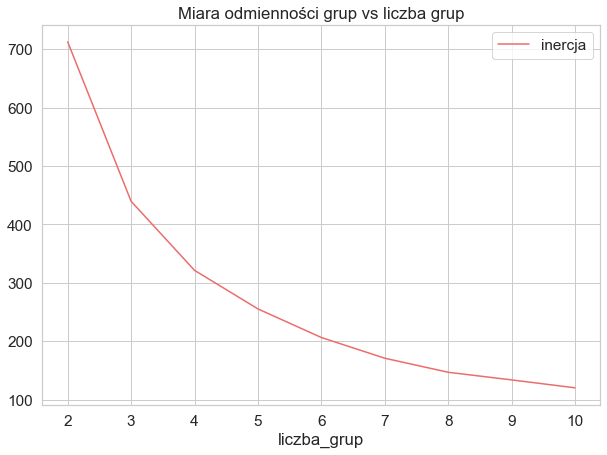

In [126]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.lineplot(data = res.drop('zysk_proc', axis = 1), palette = ['#eb6c6a']).set(title = "Miara odmienności grup vs liczba grup")
plt.show()

Wybrać optimum grup lub ustawić

### 8.3.4 Decyzja o wyborze optymalnej liczby grup?

In [127]:
optimum_n #wybrana przez wsaźnik Silhouette Score, ale czy dobry?

3

### 8.3.5 Tworzenie modelu dla optymalnej liczby grup

In [128]:
kmeans = sklearn.cluster.KMeans(n_clusters=optimum_n).fit(JIRA_Data_group_selection_scaled_df)

In [129]:
prediction = kmeans.labels_.astype(int)

In [130]:
prediction_JIRA_Data = pd.DataFrame(data=prediction, columns=['segmentation Kmean'])

Łączenie danych źródłowych

In [131]:
model_kmean_data = pd.concat([Data_group_selection,JIRA_Data_group_selection_scaled_df, prediction_JIRA_Data], axis=1) 

Wyświetlenie danych

### 8.3.6 Wizualizacja segmentacji dla optymalnej liczby grup

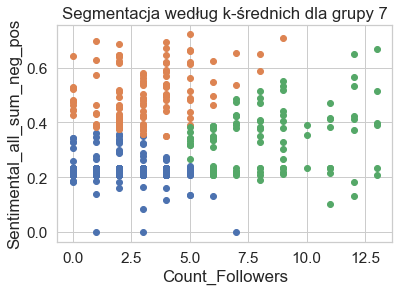

In [132]:
for i in range(0,optimum_n) :
    plt.scatter(model_kmean_data[model_kmean_data['segmentation Kmean'] == i].iloc[:, 0] , model_kmean_data[model_kmean_data['segmentation Kmean'] == i].iloc[:, 1]  )   

plt.xlabel(str(Etykiety[Etykiety["Group"]==Number_grup]['x'].iloc[0]))
plt.ylabel(str(Etykiety[Etykiety["Group"]==Number_grup]['y'].iloc[0]));
plt.title("Segmentacja według k-średnich dla grupy "+str(Etykiety[Etykiety["Group"]==Number_grup]['Group'].iloc[0]));
plt.legend;

## 8.4 Segmentacja za pomocą algorytmu K-Mediana

### 8.4.1 Import bibliotek 

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer 

### 8.4.2 Inicjacja algorytmu 

In [134]:
optimum_n=0
optimum_score=-1
res = []
for n in range(2,11):
    initial_medians = kmeans_plusplus_initializer(JIRA_Data_group_selection_scaled_df.values, n).initialize()
    kmedians_instance = kmedians(JIRA_Data_group_selection_scaled_df.values, initial_medians)
    
    kmedians_instance.process()
    clusters = kmedians_instance.get_clusters()
    centers = kmedians_instance.get_medians()
    for x in range(0,len(clusters)):
        JIRA_Data_group_selection_scaled_df.loc[JIRA_Data_group_selection_scaled_df.index.isin(clusters[x]),'segmentation Kmedian'] = x
    preds = clusterer.fit_predict(JIRA_Data_group_selection_scaled_df)
    
     
    res.append([n, clusterer.inertia_])
    score = sklearn.metrics.silhouette_score(JIRA_Data_group_selection_scaled_df, JIRA_Data_group_selection_scaled_df['segmentation Kmedian'])
    print("Dla k = {} klastrów, Silhouette Score jest równy {})".format(n, score.round(4)))
    if optimum_score < score :
        optimum_n=n
        optimum_score=score
res = pd.DataFrame(res, columns = ['liczba_grup', 'inercja'])    

print("Optymalna liczba grupu to  {} ,Wartość Silhouette Score jest równa {}".format(optimum_n, optimum_score.round(4)))


Dla k = 2 klastrów, Silhouette Score jest równy 0.5617)
Dla k = 3 klastrów, Silhouette Score jest równy 0.6294)
Dla k = 4 klastrów, Silhouette Score jest równy 0.6637)
Dla k = 5 klastrów, Silhouette Score jest równy 0.7143)
Dla k = 6 klastrów, Silhouette Score jest równy 0.7219)
Dla k = 7 klastrów, Silhouette Score jest równy 0.7304)
Dla k = 8 klastrów, Silhouette Score jest równy 0.7548)
Dla k = 9 klastrów, Silhouette Score jest równy 0.7629)
Dla k = 10 klastrów, Silhouette Score jest równy 0.7444)
Optymalna liczba grupu to  9 ,Wartość Silhouette Score jest równa 0.7629


### 8.4.4 Decyzja o wyborze optymalnej liczby grup?

In [135]:
optimum_n #wybrana przez wsaźnik Silhouette Score, ale czy dobry?

9

### 8.3.5 Tworzenie modelu dla optymalnej liczby grup

In [136]:
initial_medians = kmeans_plusplus_initializer(JIRA_Data_group_selection_scaled_df.values, optimum_n).initialize()
kmedians_instance = kmedians(JIRA_Data_group_selection_scaled_df.values, initial_medians)
    
kmedians_instance.process()
clusters = kmedians_instance.get_clusters()
centers = kmedians_instance.get_medians()
for x in range(0,len(clusters)):
    JIRA_Data_group_selection_scaled_df.loc[JIRA_Data_group_selection_scaled_df.index.isin(clusters[x]),'segmentation Kmedian'] = x
        

In [137]:
model_kmedian_data = pd.concat([Data_group_selection,JIRA_Data_group_selection_scaled_df, prediction_JIRA_Data], axis=1) 

In [138]:
model_kmedian_data

,Count_Followers,Sentimental_all_sum_neg_pos,0,1,segmentation Kmedian,segmentation Kmean
0,0,0.186,-1.000877,-0.816046,1.0,0
1,0,0.209,-1.000877,-0.627275,1.0,0
2,1,0.186,-0.652262,-0.816046,1.0,0
3,1,0.140,-0.652262,-1.193588,1.0,0
4,1,0.209,-0.652262,-0.627275,1.0,0
...,...,...,...,...,...,...
685,1,0.218,-0.652262,-0.553408,1.0,0
686,1,0.218,-0.652262,-0.553408,1.0,0
687,11,0.412,2.833881,1.038836,7.0,2
688,8,0.472,1.788038,1.531283,6.0,2


### 8.4.6 Wizualizacja segmentacji dla optymalnej liczby grup

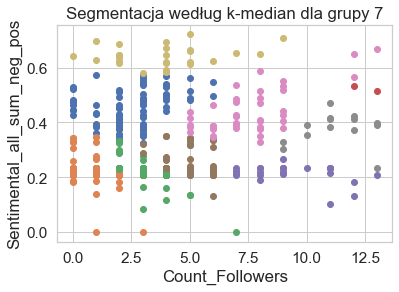

In [139]:
for i in range(0,optimum_n) :
    plt.scatter(model_kmedian_data[model_kmedian_data['segmentation Kmedian'] == i].iloc[:, 0] , model_kmedian_data[model_kmedian_data['segmentation Kmedian'] == i].iloc[:, 1]  )   

plt.xlabel(str(Etykiety[Etykiety["Group"]==Number_grup]['x'].iloc[0]))
plt.ylabel(str(Etykiety[Etykiety["Group"]==Number_grup]['y'].iloc[0]));
plt.title("Segmentacja według k-median dla grupy "+str(Etykiety[Etykiety["Group"]==Number_grup]['Group'].iloc[0]));
plt.legend;

## 8.5 Segmentacja za pomocą algorytmu DBSCAN

### 8.5.1 Import bibliotek

In [140]:
from sklearn.cluster import DBSCAN

In [141]:
from sklearn.neighbors import NearestNeighbors

In [142]:
from sklearn.metrics import silhouette_score

### 8.5.2 Oblicz odległość danych od siebie za pomocą funkcji najbliższych sąsiadów

In [143]:
neighb = NearestNeighbors(n_neighbors=2) 
nbrs=neighb.fit(JIRA_Data_group_selection_scaled_df)  
distances,indices=nbrs.kneighbors(JIRA_Data_group_selection_scaled_df)  

### 8.5.3 Sortowanie i wykreślanie odległości między punktami danych

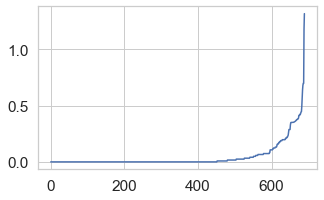

In [144]:
distances = np.sort(distances, axis = 0) 
distances = distances[:, 1] 
plt.rcParams['figure.figsize'] = (5,3) 
plt.plot(distances)
plt.show() 

### 8.5.4 Wybór parametrów

In [145]:
eps = 0.4 #należy odczytać z wykresu

In [146]:
min_samples = 4 # liczba zmiennych * 2

In [147]:
dbscan = DBSCAN(eps = 0.5, min_samples = 4).fit(JIRA_Data_group_selection_scaled_df) 
labels = dbscan.labels_ 

### 8.5.5 Obliczanie wskaźnika silhouette

In [148]:
print("DBSCAN wartość wskaźnika silhouette: {}".format(silhouette_score(Data_group_selection, labels).round(4)))

DBSCAN wartość wskaźnika silhouette: 0.2572


### 8.5.6 Wizualizacja segmentacji dla optymalnej liczby grup

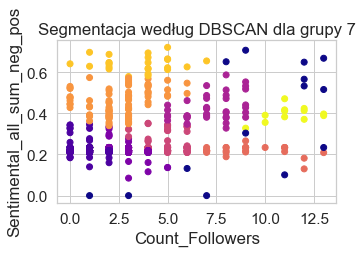

In [149]:
plt.scatter(Data_group_selection.iloc[:, 0], Data_group_selection.iloc[:, 1], c = labels, cmap= "plasma") # plotting the clusters
plt.xlabel(str(Etykiety[Etykiety["Group"]==Number_grup]['x'].iloc[0]))
plt.ylabel(str(Etykiety[Etykiety["Group"]==Number_grup]['y'].iloc[0]));
plt.title("Segmentacja według DBSCAN dla grupy "+str(Etykiety[Etykiety["Group"]==Number_grup]['Group'].iloc[0]));

plt.show() # showing the plot

Liczba grup powstałych w algorytmie DBSCAN

In [150]:
max(labels)

7